In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
from datetime import datetime

In [2]:
%load_ext autoreload
%autoreload 2

## Load Data

In [3]:
import sys
sys.path.append('../src')

In [4]:
def gen_column_names(s):
    column_names = s

    column_names = column_names.split(sep='. ')
    column_names = column_names[1:]
    column_names = [c.rstrip('0123456789').rstrip(' ') for c in column_names]

    return column_names


In [5]:
# character_columns = gen_column_names(input())
# print(character_columns)
character_columns=['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 'Actor name', 'Actor age at movie release', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']

In [6]:
# movie_columns = gen_column_names(input())
# print(movie_columns)
movie_columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)']

In [7]:
characters = pd.read_csv('./data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, names=character_columns)
movies = pd.read_csv('./data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None, names=movie_columns)

movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [8]:
characters.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [9]:
characters.shape

(450669, 13)

In [10]:
movies.shape

(81741, 9)

## group by year

In [11]:
def extract_year(x):
    return str(x)[:4]

In [12]:
characters['movie_year'] = characters['Movie release date'].apply(extract_year)
characters.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001


In [13]:
characters.movie_year.unique()

array(['2001', '2000', '1988', '1983', '2005', '2006', '1930', '1974',
       '1986', '1967', '1938', '1999', '1931', '1935', '1959', '1989',
       '2009', '1984', '2010', '1980', '2008', '1917', '1977', '1982',
       '1947', '1939', '1987', '1976', '1994', '1975', '1952', '2012',
       '2007', 'nan', '1916', '2003', '1963', '1934', '1969', '1996',
       '1915', '1973', '1956', '1979', '1929', '1954', '1997', '1995',
       '1998', '1981', '1971', '2011', '1990', '1951', '1978', '1950',
       '1955', '1953', '1945', '1932', '1957', '1993', '1965', '1913',
       '1936', '2004', '2002', '1942', '1991', '1962', '1927', '1961',
       '1958', '1949', '1992', '1933', '1966', '1941', '1944', '1924',
       '1919', '1968', '1972', '1940', '1922', '1918', '1964', '1960',
       '1914', '1948', '1946', '1985', '1912', '1943', '1970', '1923',
       '1920', '1925', '1926', '1921', '2013', '1937', '1894', '1928',
       '2014', '1911', '1898', '1909', '1900', '1907', '1906', '1910',
       

movie year存在两组异常值：1. 数据填错了， 2010写成了1010 2.没有发布日期的数据

In [14]:
characters[characters['movie_year']=='nan']

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,movie_year
337,27374355,/m/0by1_ff,NaN,NaN,1953-03-16,F,1.60,NaN,Isabelle Huppert,NaN,/m/0bykcy4,NaN,/m/012g92,nan
494,10792038,/m/02qq3mb,NaN,NaN,1950-12-12,M,1.75,/m/0cqgdq,Rajnikanth,NaN,/m/03kxr5d,NaN,/m/02wmbg,nan
519,11717027,/m/02rpz18,NaN,NaN,1908-05-30,M,NaN,/m/041rx,Mel Blanc,NaN,/m/052c_g2,NaN,/m/0c5vh,nan
520,10628777,/m/02qkn7c,NaN,NaN,1964-01-15,F,1.69,NaN,Bhanupriya,NaN,/m/0jmx_q5,NaN,/m/08mdtm,nan
521,10628777,/m/02qkn7c,NaN,NaN,1972-07-18,F,NaN,NaN,Soundarya,NaN,/m/0jmx290,NaN,/m/02vd_b,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450334,29119097,/m/0dlmtgr,NaN,NaN,NaN,M,NaN,NaN,Biswajit Chakraborty,NaN,/m/0hhz7cc,NaN,/m/0dgsd62,nan
450494,17198681,/m/043mrjw,NaN,NaN,1970-03-23,F,NaN,NaN,Melissa Errico,NaN,/m/0cmxspd,NaN,/m/0269llv,nan
450495,17198681,/m/043mrjw,NaN,Barbie Loving Bartender,1965-09-03,M,1.75,/m/042gtr,Charlie Sheen,NaN,/m/04fz126,/m/04fz129,/m/01pllx,nan
450496,17198681,/m/043mrjw,NaN,Make-up Lady,1967-04-02,F,NaN,/m/042gtr,Renée Estevez,NaN,/m/0h5mg_5,/m/0h5mg_7,/m/0331rx,nan


In [15]:
characters[characters['movie_year']=='1010']

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,movie_year
67624,29666067,/m/0fphzrf,1010-12-02,Kamuran,1983,M,NaN,NaN,Bartu Küçükçaglayan,NaN,/m/0n4fxh5,/m/0n4fxh8,/m/0df0qkt,1010
67625,29666067,/m/0fphzrf,1010-12-02,Ferman,1941-12-26,M,NaN,NaN,Şener Şen,NaN,/m/0gb33kh,/m/0n4fgzm,/m/02z247j,1010
67626,29666067,/m/0fphzrf,1010-12-02,Idris,1973-04-23,M,NaN,NaN,Cem Yılmaz,NaN,/m/0gb33kn,/m/0n4flr2,/m/0fz9xn,1010
67627,29666067,/m/0fphzrf,1010-12-02,Hasan,1978-12-13,M,NaN,NaN,Okan Yalabık,NaN,/m/0ggd8h0,/m/0n4fsc3,/m/0cmb83k,1010
67628,29666067,/m/0fphzrf,1010-12-02,Battal,1945-07-16,M,NaN,NaN,Çetin Tekindor,NaN,/m/0h9dtmf,/m/0n4frvc,/m/0ch5v5f,1010
67629,29666067,/m/0fphzrf,1010-12-02,Asiye,1985-07-06,F,NaN,NaN,Melisa Sözen,NaN,/m/0k3m4yc,/m/0n4fs00,/m/0ch3v_t,1010
67630,29666067,/m/0fphzrf,1010-12-02,Asit Omer,NaN,M,NaN,NaN,Riza Kocaoglu,NaN,/m/0n4fssj,/m/0n4fssm,/m/0n4fssv,1010
67631,29666067,/m/0fphzrf,1010-12-02,Hatun,NaN,F,NaN,NaN,Nergis Çorakçi,NaN,/m/0n4ftj1,/m/0n4ftj4,/m/0n4ftjc,1010
67632,29666067,/m/0fphzrf,1010-12-02,Müslüm,1963,M,NaN,NaN,Mustafa Avkiran,NaN,/m/0n4fv9p,/m/0n4fv9s,/m/0gc9xb7,1010
67633,29666067,/m/0fphzrf,1010-12-02,Murat Önes,NaN,M,NaN,NaN,Mahir Ipek,NaN,/m/0n4fvtw,/m/0n4fvtz,/m/0n4fvv5,1010


In [16]:
characters[characters['movie_year']=='1010']['movie_year']='2010'

In [17]:
characters[characters['movie_year']=='1010']

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,movie_year
67624,29666067,/m/0fphzrf,1010-12-02,Kamuran,1983,M,NaN,NaN,Bartu Küçükçaglayan,NaN,/m/0n4fxh5,/m/0n4fxh8,/m/0df0qkt,1010
67625,29666067,/m/0fphzrf,1010-12-02,Ferman,1941-12-26,M,NaN,NaN,Şener Şen,NaN,/m/0gb33kh,/m/0n4fgzm,/m/02z247j,1010
67626,29666067,/m/0fphzrf,1010-12-02,Idris,1973-04-23,M,NaN,NaN,Cem Yılmaz,NaN,/m/0gb33kn,/m/0n4flr2,/m/0fz9xn,1010
67627,29666067,/m/0fphzrf,1010-12-02,Hasan,1978-12-13,M,NaN,NaN,Okan Yalabık,NaN,/m/0ggd8h0,/m/0n4fsc3,/m/0cmb83k,1010
67628,29666067,/m/0fphzrf,1010-12-02,Battal,1945-07-16,M,NaN,NaN,Çetin Tekindor,NaN,/m/0h9dtmf,/m/0n4frvc,/m/0ch5v5f,1010
67629,29666067,/m/0fphzrf,1010-12-02,Asiye,1985-07-06,F,NaN,NaN,Melisa Sözen,NaN,/m/0k3m4yc,/m/0n4fs00,/m/0ch3v_t,1010
67630,29666067,/m/0fphzrf,1010-12-02,Asit Omer,NaN,M,NaN,NaN,Riza Kocaoglu,NaN,/m/0n4fssj,/m/0n4fssm,/m/0n4fssv,1010
67631,29666067,/m/0fphzrf,1010-12-02,Hatun,NaN,F,NaN,NaN,Nergis Çorakçi,NaN,/m/0n4ftj1,/m/0n4ftj4,/m/0n4ftjc,1010
67632,29666067,/m/0fphzrf,1010-12-02,Müslüm,1963,M,NaN,NaN,Mustafa Avkiran,NaN,/m/0n4fv9p,/m/0n4fv9s,/m/0gc9xb7,1010
67633,29666067,/m/0fphzrf,1010-12-02,Murat Önes,NaN,M,NaN,NaN,Mahir Ipek,NaN,/m/0n4fvtw,/m/0n4fvtz,/m/0n4fvv5,1010


In [18]:
charaters_with_year = characters[characters['movie_year']!='nan']
charaters_with_year = charaters_with_year[charaters_with_year['movie_year']!='1010']
charaters_with_year['movie_year'] = charaters_with_year['movie_year'].apply(lambda x: int(x))

In [19]:
female = charaters_with_year[charaters_with_year['Actor gender']=='F']
male = charaters_with_year[charaters_with_year['Actor gender']=='M']
female = female[female['Actor age at movie release']>=0]
male = male[male['Actor age at movie release']>=0]

In [20]:
female_year_grouped = female.groupby(by='movie_year')
male_year_grouped= male.groupby(by='movie_year')

In [21]:
female_year_grouped.size()

movie_year
1888       2
1894       1
1896       5
1897       2
1898       1
        ... 
2012    2545
2013     281
2014      15
2015       2
2016       2
Length: 121, dtype: int64

In [22]:
female_years = female_year_grouped.agg({
    'Actor height (in meters)':['min','max', 'mean'],
    'Actor age at movie release': ['min','max','mean']
    }
)
female_years.columns = female_years.columns.to_flat_index()
female_years['nums'] = female_year_grouped.size()
female_years

,"(Actor height (in meters), min)","(Actor height (in meters), max)","(Actor height (in meters), mean)","(Actor age at movie release, min)","(Actor age at movie release, max)","(Actor age at movie release, mean)",nums
movie_year,,,,,,,
1888,NaN,NaN,NaN,NaN,NaN,NaN,2
1894,NaN,NaN,NaN,NaN,NaN,NaN,1
1896,NaN,NaN,NaN,NaN,NaN,NaN,5
1897,NaN,NaN,NaN,NaN,NaN,NaN,2
1898,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...
2012,1.17,1.91,1.667058,7.0,90.0,35.700980,2545
2013,1.27,1.83,1.667524,13.0,86.0,34.637795,281
2014,1.52,1.73,1.653000,15.0,64.0,35.928571,15


In [23]:
male_years = male_year_grouped.agg({
    'Actor height (in meters)':['min','max', 'mean'],
    'Actor age at movie release':  ['min','max','mean']
    }
)
male_years.columns = male_years.columns.to_flat_index()
male_years['nums'] = male_year_grouped.size()
male_years

,"(Actor height (in meters), min)","(Actor height (in meters), max)","(Actor height (in meters), mean)","(Actor age at movie release, min)","(Actor age at movie release, max)","(Actor age at movie release, mean)",nums
movie_year,,,,,,,
1888,NaN,NaN,NaN,NaN,NaN,NaN,2
1891,NaN,NaN,NaN,NaN,NaN,NaN,1
1893,NaN,NaN,NaN,NaN,NaN,NaN,2
1894,NaN,NaN,NaN,NaN,NaN,NaN,3
1895,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...
2012,0.813,510.000,2.126179,-37.0,103.0,43.827682,4502
2013,1.320,2.100,1.802094,11.0,90.0,43.590909,643
2014,1.680,1.981,1.815562,14.0,76.0,41.400000,21


### gender difference on character population

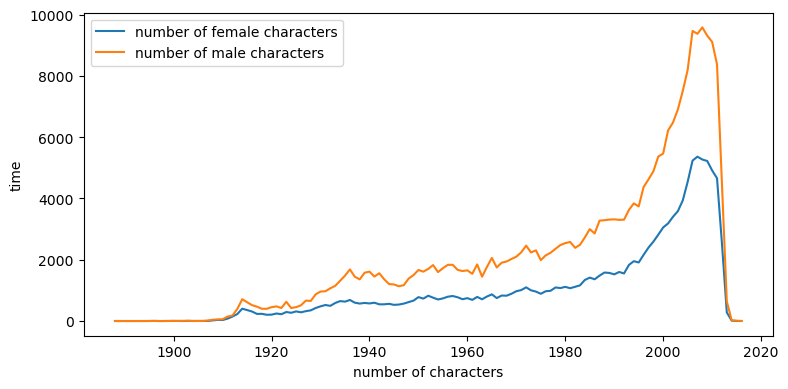

In [24]:
plt.figure(figsize=(8,4))


ax = sns.lineplot(data = female_years, x = "movie_year", y = "nums", legend = "full", label = "number of female characters")
ax = sns.lineplot(data = male_years, x = "movie_year", y = "nums", legend = "full", label = "number of male characters")


plt.xlabel("number of characters")
plt.ylabel("time")
plt.tight_layout()
plt.show()

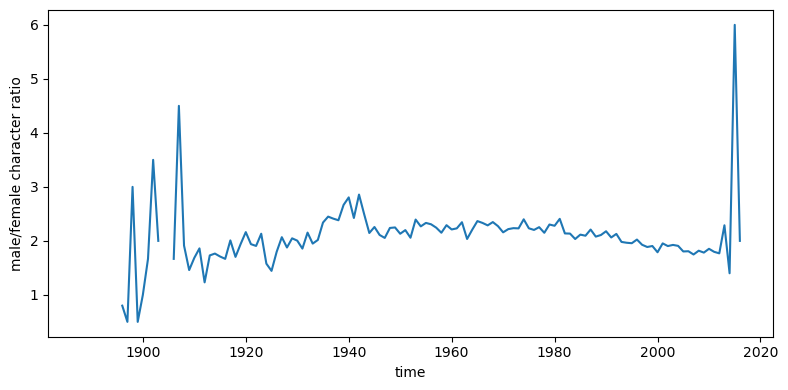

In [25]:
plt.figure(figsize=(8,4))

ratio = male_years['nums'] / female_years['nums'] 
plt.plot(male_years.index, ratio)


plt.xlabel("time")
plt.ylabel("male/female character ratio")
plt.tight_layout()
plt.show()

In [26]:
print([idx if idx not in female_years.index else '' for idx in male_years.index ])


['', 1891, 1893, '', 1895, '', '', '', '', '', '', '', '', 1904, 1905, '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']



Male characters are always more than female characters, showing insufficient chances for actresses.
The uneven distribution turned slightly better in 21th century but is not good enough.

In [27]:
female_years.fillna(0)
male_years.fillna(0)

,"(Actor height (in meters), min)","(Actor height (in meters), max)","(Actor height (in meters), mean)","(Actor age at movie release, min)","(Actor age at movie release, max)","(Actor age at movie release, mean)",nums
movie_year,,,,,,,
1888,0.000,0.000,0.000000,0.0,0.0,0.000000,2
1891,0.000,0.000,0.000000,0.0,0.0,0.000000,1
1893,0.000,0.000,0.000000,0.0,0.0,0.000000,2
1894,0.000,0.000,0.000000,0.0,0.0,0.000000,3
1895,0.000,0.000,0.000000,0.0,0.0,0.000000,1
...,...,...,...,...,...,...,...
2012,0.813,510.000,2.126179,-37.0,103.0,43.827682,4502
2013,1.320,2.100,1.802094,11.0,90.0,43.590909,643
2014,1.680,1.981,1.815562,14.0,76.0,41.400000,21


### gender difference on average age

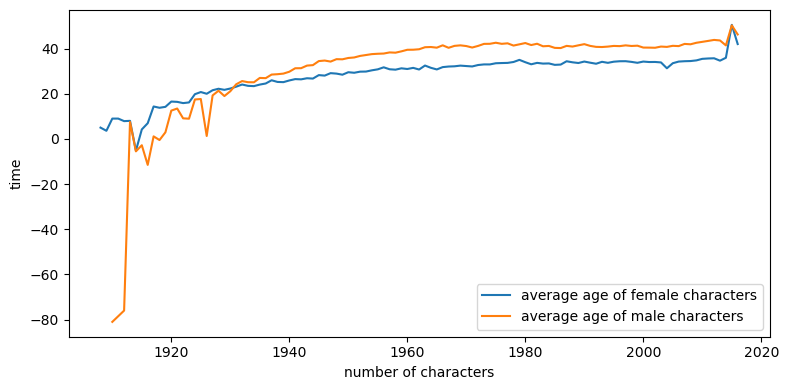

In [28]:
plt.figure(figsize=(8,4))


ax = sns.lineplot(
    data = female_years, x = "movie_year", y = ('Actor age at movie release', 'mean'), 
    legend = "full", label = "average age of female characters"

    )
ax = sns.lineplot(
    data = male_years, x = "movie_year", y = ('Actor age at movie release', 'mean') , 
    legend = "full", label = "average age of male characters"
    )


plt.xlabel("number of characters")
plt.ylabel("time")
plt.tight_layout()
plt.show()

In [53]:
female_age = female['Actor age at movie release'].values
male_age = male['Actor age at movie release'].values
female_age = female_age[~np.isnan(female_age)]
female_age = female_age[female_age>0]  # remove abnormal points.
male_age = male_age[~np.isnan(male_age)]
male_age = male_age[male_age>0]
age_dis = [female_age, male_age]
age_dis[0]

array([42., 27., 23., ..., 22., 25., 34.])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9f873db460>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9f873dba00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9f873db2b0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9f873dbfa0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9f873e32b0>,
 'means': []}

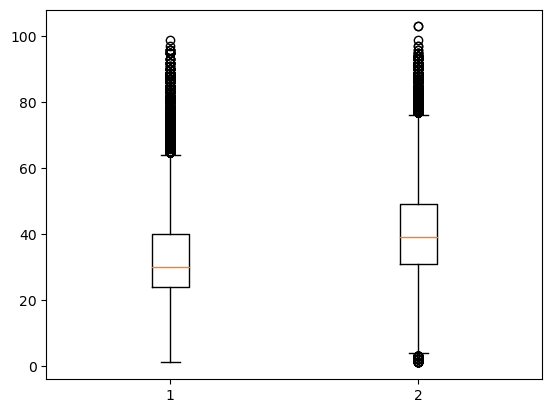

In [54]:
plt.boxplot(age_dis)

**Question**: is the plots above sufficient to say that female charaters are generally younger than male actors, so actresses have a rather short career span -----> career oportunities